In [1]:
# others
import pandas as pd
import numpy as np
import argparse
import datetime
from copy import deepcopy # Add Deepcopy for args
import pickle 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)


1.7.1
Populating the interactive namespace from numpy and matplotlib


In [23]:
# read file
train_x_df = pd.read_csv("./data/train_x_df.csv")
train_y_df = pd.read_csv("./data/train_y_df.csv")

coin_9_x_df = train_x_df[train_x_df['coin_index'] ==  9]
coin_9_y_df = train_y_df[train_y_df['coin_index'] ==  9]

In [2]:
''' greedy feature handleing'''
# test_df = train_x_df[train_x_df['volume'] != 0]
# test_df['rest_asset'] = test_df['volume'] - test_df['tb_base_av']
# test_df['greedy'] = test_df['tb_base_av'] / test_df['volume']

# test_df2 = test_df[['time', 'coin_index', 'open', 'high', 'low', 'close', 'volume', 'trades', 'tb_base_av','rest_asset', 'greedy']]
# test_df2[['coin_index','trades', 'volume', 'tb_base_av','rest_asset', 'greedy']].head()
# test_df2[test_df2['greedy'] == 1][['coin_index','trades', 'volume', 'tb_base_av','rest_asset', 'greedy']].head()

' greedy feature handleing'

In [6]:
# numpy arrary conversion

def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())

    # 2위 팀에서 임의로 넣어둠
    # sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


In [42]:
print(f'''

coin_9_x_df {coin_9_x_df.shape}
coin_9_y_df {coin_9_y_df.shape}
merged_df ({coin_9_x_df.shape[0] + coin_9_y_df.shape[0]}, {coin_9_x_df.shape[1] })
''')



coin_9_x_df (1667040, 12)
coin_9_y_df (144960, 12)
merged_df (1812000, 12)



In [67]:
coin_9_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
10568035,7657,1375,9,1.000446,1.000587,1.000195,1.000318,0.001036,7.397388,0.017940,0.000382,2.727105
10568036,7657,1376,9,1.000320,1.000391,1.000136,1.000151,0.001523,10.870192,0.022144,0.000624,4.455104
10568037,7657,1377,9,1.000292,1.000293,0.999805,0.999957,0.003475,24.795588,0.038402,0.000871,6.217534
10568038,7657,1378,9,0.999830,1.000130,0.999821,1.000102,0.000879,6.268497,0.015277,0.000391,2.789685


In [68]:
coin_9_y_df.time = coin_9_y_df.time + 1380

C:\Anaconda3\envs\venv\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [69]:
coin_9_y_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,1380,9,0.999389,0.999630,0.999261,0.999385,0.001187,9.632785,0.012565,0.000605,4.904978
1,0,1381,9,0.999593,1.000000,0.999265,0.999266,0.004197,34.052364,0.020572,0.003014,24.453999
2,0,1382,9,0.999266,0.999618,0.999262,0.999322,0.003942,31.981472,0.016630,0.002967,24.069899
3,0,1383,9,0.999322,0.999388,0.998917,0.999387,0.003663,29.709074,0.019463,0.002362,19.158766
4,0,1384,9,0.999015,0.999015,0.997631,0.998399,0.003266,26.466251,0.030180,0.001533,12.421005
...,...,...,...,...,...,...,...,...,...,...,...,...
918955,7657,1495,9,1.005850,1.008398,1.005714,1.008084,0.018440,132.533844,0.166922,0.011676,83.914566
918956,7657,1496,9,1.008109,1.008259,1.006929,1.007139,0.016465,118.390549,0.097126,0.006409,46.085777
918957,7657,1497,9,1.007186,1.007418,1.005802,1.006216,0.006134,44.051334,0.060266,0.001914,13.744169
918958,7657,1498,9,1.006092,1.007211,1.004988,1.005507,0.010358,74.361237,0.086474,0.004091,29.376879


In [70]:
merged_df = pd.concat([coin_9_x_df, coin_9_y_df])

In [71]:
merged_df[merged_df['sample_id'] == 0]

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
115,0,1495,9,0.999015,0.999444,0.998602,0.999138,0.002013,16.322132,0.009855,0.000913,7.404432
116,0,1496,9,0.999137,0.999258,0.998645,0.998768,0.001406,11.402768,0.013427,0.000246,1.997674
117,0,1497,9,0.998768,0.999261,0.998602,0.998965,0.002410,19.541895,0.021064,0.000408,3.311697
118,0,1498,9,0.998965,0.999255,0.998650,0.999255,0.000869,7.047903,0.008500,0.000241,1.957937


0
375
750
1125


[]

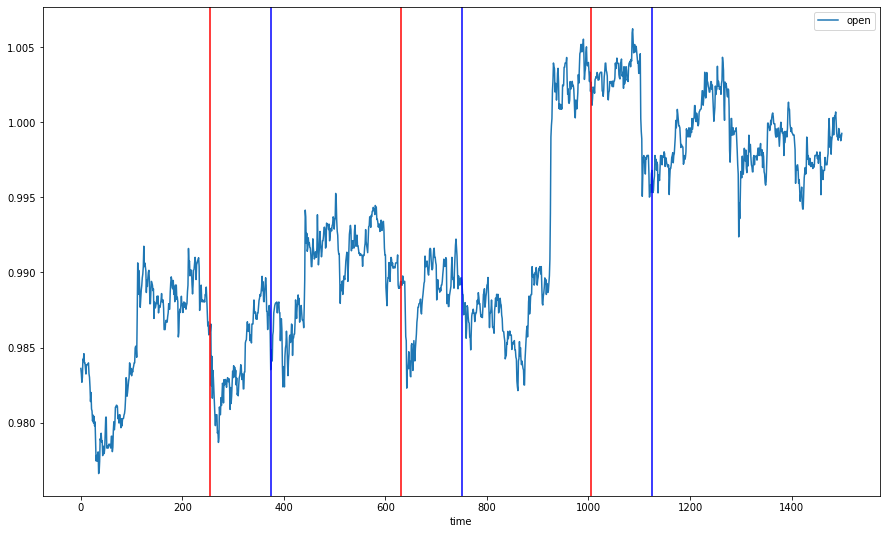

In [110]:
import matplotlib.pyplot as plt
a = merged_df[merged_df['sample_id'] == 0].plot(x='time',y=['open'])

for i in range(0, 1499, 375):
    print(i)
    if i != 0:
        # print(i-120, i)
        plt.axvline(x= i-120, color = 'r')
        plt.axvline(x= i, color = 'b')

a.plot()



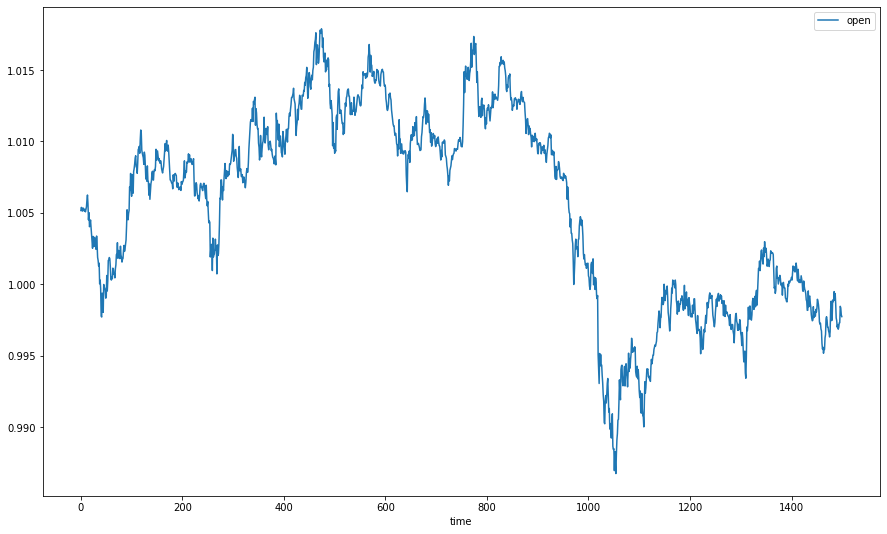

In [123]:
merged_df[merged_df['sample_id'] == 1].plot(x='time',y=['open'])

In [61]:
merged_df.sample_id.unique()

array([   0,    1,    9, ..., 7652, 7653, 7657], dtype=int64)

In [28]:
merged_df[merged_df.sample_id == 0]

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
115,0,115,9,0.999015,0.999444,0.998602,0.999138,0.002013,16.322132,0.009855,0.000913,7.404432
116,0,116,9,0.999137,0.999258,0.998645,0.998768,0.001406,11.402768,0.013427,0.000246,1.997674
117,0,117,9,0.998768,0.999261,0.998602,0.998965,0.002410,19.541895,0.021064,0.000408,3.311697
118,0,118,9,0.998965,0.999255,0.998650,0.999255,0.000869,7.047903,0.008500,0.000241,1.957937


In [111]:
df = df2d_to_array3d(merged_df)

In [113]:
df.shape

(1208, 1500, 10)

In [117]:
merged_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
918955,7657,1495,9,1.005850,1.008398,1.005714,1.008084,0.018440,132.533844,0.166922,0.011676,83.914566
918956,7657,1496,9,1.008109,1.008259,1.006929,1.007139,0.016465,118.390549,0.097126,0.006409,46.085777
918957,7657,1497,9,1.007186,1.007418,1.005802,1.006216,0.006134,44.051334,0.060266,0.001914,13.744169
918958,7657,1498,9,1.006092,1.007211,1.004988,1.005507,0.010358,74.361237,0.086474,0.004091,29.376879


In [162]:
 resetindex_df = merged_df.sample_id.value_counts().reset_index().rename(columns = {"index" : "sample_id"})

In [172]:
resetindex_df.iloc[:,:1].sort_values(by = ['sample_id']).reset_index(drop=True)

,sample_id
0,0
1,1
2,9
3,17
4,18
...,...
1203,7625
1204,7631
1205,7652
1206,7653


In [176]:
merged_df.sample_id

0            0
1            0
2            0
3            0
4            0
          ... 
918955    7657
918956    7657
918957    7657
918958    7657
918959    7657
Name: sample_id, Length: 1812000, dtype: int64

In [178]:
merged_df.sample_id

0            0
1            0
2            0
3            0
4            0
          ... 
918955    7657
918956    7657
918957    7657
918958    7657
918959    7657
Name: sample_id, Length: 1812000, dtype: int64

In [190]:
merged_df = merged_df.sort_values(by = ['sample_id','time']).reset_index(drop=True)

In [195]:
merged_df[merged_df['sample_id'] == ]

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
3000,9,0,9,1.010934,1.011488,1.010130,1.010236,0.000753,27.401535,0.022036,0.000474,17.226742
3001,9,1,9,1.010236,1.011221,1.010236,1.010908,0.000768,27.922123,0.024148,0.000398,14.468545
3002,9,2,9,1.010907,1.011303,1.010099,1.011053,0.000810,29.469751,0.026232,0.000441,16.055786
3003,9,3,9,1.011053,1.011916,1.010649,1.011776,0.000836,30.407820,0.031873,0.000353,12.859076
3004,9,4,9,1.011776,1.013012,1.011693,1.012930,0.000994,36.221241,0.032623,0.000558,20.337631
...,...,...,...,...,...,...,...,...,...,...,...,...
4495,9,1495,9,0.975498,0.976540,0.973935,0.973935,0.000667,23.396793,0.024120,0.000230,8.064309
4496,9,1496,9,0.974009,0.975197,0.972864,0.975197,0.000995,34.858490,0.027927,0.000504,17.646919
4497,9,1497,9,0.975197,0.976448,0.974016,0.975480,0.000872,30.601618,0.028900,0.000373,13.094083
4498,9,1498,9,0.975480,0.976907,0.974571,0.976171,0.000969,34.022884,0.026899,0.000606,21.293859


In [196]:
np.where(merged_df.sample_id == 0, 0, 1)

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
def transform_colvalue(df, col_name):
    series = df[col_name]        
    df[col_name] = np.where(series <= 0.5, 1/series*-1, series)
    return df

In [175]:
print(resetindex_df.index[0])

0


In [ ]:
    sample_size = len(df_2d.sample_id.value_counts())

    # 2위 팀에서 임의로 넣어둠
    # sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [20]:
coin_9_y_df.shape

(1208, 120, 10)

어차피 시간대 별 특성이 없다고 치면. 코인 인덱스가 같으면. 

datasetgenerate로 0 ~ 1000까지 샘플 가지고 오고.
1. 샘플을 가져와서 

1, 1500, 12 - 

In [122]:
class DatasetGenerater(Dataset):
    '''설명 : '''
    
    def __init__(self, dataframe, x_frames, y_frames):

        '''
        : param dataframe:   Raw data to load for making dataset
        : param x_frames:    the number of input day size
        : param y_frames:    the number of output day size
        '''
        self.dataframe = dataframe
        self.x_frames = x_frames
        self.y_frames = y_frames

        check_null = self.dataframe.isna().sum().sum()
        print("null clear") if check_null == 0 else print("null exist")
        
        
    def __len__(self):
        return len(self.dataframe) - (self.x_frames + self.y_frames) + 1
    
    
    def __getitem__(self, idx):
        idx += self.x_frames
        
        dataframe = self.dataframe.iloc[idx-self.x_frames:idx+self.y_frames]
        dataframe = dataframe.values
        
        X = dataframe[:self.x_frames]
        y = dataframe[self.x_frames:]
        
        return X, y